In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)

from functools import reduce
import random
from tqdm import tqdm
import face_recognition

[face_recognition example](https://github.com/ageitgey/face_recognition/blob/master/examples/facerec_from_webcam_faster.py)

In [26]:
def load_images(path, image_type='.jpg'):
    images = []
    for file_path in glob.glob(os.path.join(path, f'*{image_type}')):
        images.append(cv2.imread(file_path))
        # Convert BGR to RGB
        images[-1] = images[-1][:, :, ::-1]
    return images

def new_load_images(glob_path):
    images = []
    for file_path in glob.glob(glob_path):
        images.append(cv2.imread(file_path))
        # Convert BGR to RGB
        images[-1] = cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB)
#         images[-1] = images[-1][:, :, ::-1]
    return images

def use_tqdm(iterable, desc=None, total=None):
    total = total or len(iterable)
    return tqdm(iterable, total=total, desc=desc, ncols=100, position=0, leave=True)

In [3]:
def encode_face(img):
    return face_recognition.face_encodings(img)[0]

def encode_faces(img, locations):
    return face_recognition.face_encodings(img, locations)

def locate_faces(img):
    return face_recognition.face_locations(img)

def face_distance(face1, face2):
    return np.linalg.norm(face1 - face2, axis=1)

def compare_faces(face1, face2, tolerance=0.6):
    return list(face_distance(face1, face2) <= tolerance)

In [4]:
# Load photo with the person
person_image = load_images('soty_photos', image_type='boris.jpg')[0]
person_name = 'Boris'

In [5]:
# Get person face features
person_encoding = encode_face(person_image).reshape(1, -1)

In [6]:
# List folders

folders = glob.glob('soty_photos/*/*')
print(np.array(folders))

['soty_photos/Slippers of the Year 2019/boris'
 'soty_photos/Slippers of the Year 2019/ivan'
 'soty_photos/Slippers of the Year 2019/noone']


In [33]:
# Load images
images = []
for folder in folders[:1]:
    images.extend(load_images(folder))

# images = new_load_images('soty_photos/*/*/*.jpg')
images = np.array(images)
images.shape

(7, 2000, 3000, 3)

In [10]:
images_with_person = []
# print('Num of images to process:', len(images))
for i, img in use_tqdm(enumerate(images),desc="Finding faces in images",total= len(images)):
    # Scale down for faster processing
    scale = 0.5
    small_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
    
    # Face detection
    face_locations = locate_faces(small_img)
    
    # Face extraction
    face_encodings = encode_faces(small_img, face_locations)
    # If no faces found, skip this image
    if not face_encodings:
        continue
    
    # Face recognition
    matches = compare_faces(person_encoding, face_encodings)
    if any(matches):
        images_with_person.append(i)

Finding faces in images: 100%|████████████████████████████████████████| 7/7 [00:32<00:00,  4.65s/it]


In [11]:
images_with_person[:10]

[0, 1, 2, 3, 4, 5, 6]

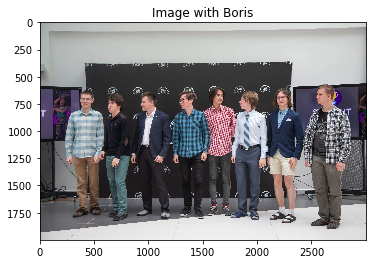

No images without Boris


In [13]:
mask = np.zeros(len(images), dtype=bool)
mask[images_with_person] = True

if any(mask):
    plt.imshow(random.choice(images[mask]))
    plt.title(f'Image with {person_name}')
    plt.show()
else:
    print('No images with', person_name)

if any(~mask):
    plt.imshow(random.choice(images[~mask]))
    plt.title(f'Image without {person_name}')
    plt.show()
else:
    print('No images without', person_name)